Load data

In [1]:
import imageio
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
import pandas as pd

In [2]:
path = "data/HDR/"
image = imageio.imread(path+'new_p1s1-20200909-130132-96.hdr',format="HDR-FI")

In [3]:
image.shape


(800, 800, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


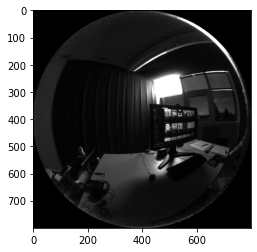

In [4]:
plt.imshow(image)

plt.show()

In [5]:
cat=[]
name_img=[]
for file in os.listdir(path):
    if os.path.isfile(os.path.join(path,file)) == True:
        c=os.path.basename(file)
        name=path + c
        name_img.append(name)
        image = imageio.imread(name,format="HDR-FI")
        cat.append(image)

cat=np.array(cat)
print(cat.shape)

(252, 800, 800, 3)


In [6]:
dgpcsv = pd.read_csv("./data/dgp.csv")
dgpcsv = dgpcsv[['Index','discomfort','Scene']].values
print(dgpcsv[:10])   

[[1 'No' '1-panel_low']
 [1 'No' '2-panel_low']
 [1 'No' '2-panel_high']
 [1 'Yes' '1-panel_high']
 [2 'No' '1-panel_low']
 [2 'No' '1-panel_high']
 [2 'No' '2-panel_low']
 [2 'Yes' '2-panel_high']
 [3 'Yes' '2-panel_low']
 [3 'Yes' '1-panel_low']]


In [7]:
xdata=[]
for i in range(252):
    if dgpcsv[i][1]=='No':
        xdata.append([0,1])
    elif dgpcsv[i][1]=='Yes':
        xdata.append([1,0])
print(len(xdata),xdata[:5])

252 [[0, 1], [0, 1], [0, 1], [1, 0], [0, 1]]


In [8]:
xtrain = np.array(cat[:200])
ytrain = np.array(xdata[:200])
xtest = np.array(cat[201:])
ytest = np.array(xdata[201:])

In [9]:
print(xtrain.shape,np.array(ytrain).shape)

(200, 800, 800, 3) (200, 2)


In [12]:
def cnn_model(input_shape, num_classes):
    
    model = tf.keras.Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D((10,10)))
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(MaxPooling2D((5,5)))
    
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(MaxPooling2D((5,5)))
    
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return(model)

In [13]:
model = cnn_model(xtrain.shape[1:], 2)

In [14]:
def train_model(model, x, y, x_test, y_test, batch_size=28, epochs=10):

    x=np.array(x)
    y=np.array(y)
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    model.fit(x, y, batch_size = batch_size, epochs = epochs, validation_data=(x_test, y_test) )

In [15]:
train_model(model, xtrain, ytrain, xtest, ytest)

Epoch 1/10
8/8 [==============================] - 29s 3s/step - loss: 1.0109 - accuracy: 0.5100 - val_loss: 0.9028 - val_accuracy: 0.5294
Epoch 2/10
8/8 [==============================] - 25s 3s/step - loss: 0.7202 - accuracy: 0.5700 - val_loss: 0.6823 - val_accuracy: 0.5294
Epoch 3/10
8/8 [==============================] - 26s 3s/step - loss: 0.6682 - accuracy: 0.5950 - val_loss: 0.7081 - val_accuracy: 0.5294
Epoch 4/10
8/8 [==============================] - 25s 3s/step - loss: 0.6569 - accuracy: 0.5700 - val_loss: 0.6861 - val_accuracy: 0.5294
Epoch 5/10
8/8 [==============================] - 25s 3s/step - loss: 0.6573 - accuracy: 0.6000 - val_loss: 0.8722 - val_accuracy: 0.4706
Epoch 6/10
8/8 [==============================] - 25s 3s/step - loss: 0.7143 - accuracy: 0.5550 - val_loss: 0.6753 - val_accuracy: 0.5686
Epoch 7/10
8/8 [==============================] - 25s 3s/step - loss: 0.6488 - accuracy: 0.6450 - val_loss: 0.7213 - val_accuracy: 0.5294
Epoch 8/10
8/8 [==================

In [22]:
def predict(model, x):
    pred=model.predict(x)
    return pred

In [25]:
print (predict(model,cat[:10]))

[[0.14568998 0.85431   ]
 [0.36824632 0.63175374]
 [0.29036233 0.70963764]
 [0.38154954 0.61845046]
 [0.38034904 0.61965096]
 [0.26108497 0.738915  ]
 [0.2611326  0.73886734]
 [0.38225892 0.6177411 ]
 [0.36987382 0.6301262 ]
 [0.38483825 0.6151618 ]]


The prediction is in form [Yes,No]

In [26]:
situation = ['1-panel_low','1-panel_high','2-panel_low','2-panel_high']
num_situation = [0,1,2,3]
x_situation = [
                [1,0,0,0],
                [0,1,0,0],
                [0,0,1,0],
                [0,0,0,1]
]

dgplist=[]
no_sum = [0]*4
sumlist = [0]*4

for i in range(252):
    sit = dgpcsv[i][2]
    for j in range(4):
        if sit == situation [j]:
            sumlist[j]+=1
            if dgpcsv[i][1]=='No':
                no_sum[j]+=1
            elif dgpcsv[i][1]!='Yes':
                print('number: ',i,' error not y/n')
for i in no_sum:
    dgplist.append(i/63)
print(dgplist)

dgp_img=[]
for i in range(252):
    sit = dgpcsv[i][2]
    for j in range(4):
        if sit == situation [j]:
            dgp_img.append(dgplist[j])
    
            
print(len(dgp_img),dgp_img[:5])

[0.5396825396825397, 0.5873015873015873, 0.6349206349206349, 0.5555555555555556]
252 [0.5396825396825397, 0.6349206349206349, 0.5555555555555556, 0.5873015873015873, 0.5396825396825397]


In [30]:
prediction_dgp = predict(model,cat)

Average percentage difference in values between model predictions and experimental results

In [33]:
err_sum = 0
for i in range(252):
    err_sum += abs( prediction_dgp[i][1] - dgp_img[i] )/prediction_dgp[i][1]
err_rate_ev=err_sum / 252
print(err_rate_ev*100, '%')

13.555874533959086 %
